<font color = blue><font size = 6> 실험설명 </font></font><br>
이미 이전에 1step에서 RNN기반이 1step의 예측에 대해서 좋지 않다는 것을 몸소 경험했다 하지만 Online-learning에서는 좀 다른 결과가 나올까 기대감에 진행해 보았다<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/2.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,4.011808
1,4.016080
2,3.993376
3,3.981656
4,3.996736
...,...
38875,7.981184
38876,7.982088
38877,7.980072
38878,7.974312


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/online_learning_seq2seq']

In [5]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [6]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_500389/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
x_seq

tensor([[[4.0118, 4.0161, 3.9934,  ..., 3.6152, 3.6267, 3.6200]],

        [[4.0161, 3.9934, 3.9817,  ..., 3.6267, 3.6200, 3.6516]],

        [[3.9934, 3.9817, 3.9967,  ..., 3.6200, 3.6516, 3.6531]],

        ...,

        [[7.7640, 7.7670, 7.7750,  ..., 7.9441, 7.9435, 7.9443]],

        [[7.7670, 7.7750, 7.7782,  ..., 7.9435, 7.9443, 7.9404]],

        [[7.7750, 7.7782, 7.7969,  ..., 7.9443, 7.9404, 7.9387]]],
       device='cuda:0')

In [12]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),8*1e-6)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(300): #동일조건을 위해
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
#    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

smape 199.9998530449226 %
smape 199.99970381720024 %
smape 199.5525036220662 %
smape 196.8749891665944 %
smape 193.9432039595487 %
smape 191.23546937752883 %
smape 188.510834668812 %
smape 185.68060244733132 %
smape 182.68894064496135 %
smape 179.53054708346986 %
smape 176.2394284504896 %
smape 172.81452618147196 %
smape 169.20843353048403 %
smape 165.40494178470811 %
smape 161.44973103763067 %
smape 157.3987609182882 %
smape 153.2880450968157 %
smape 149.14522969931886 %
smape 145.02334756460803 %
smape 140.9941391638148 %
smape 137.10270290486298 %
smape 133.3723983848304 %
smape 129.8182373576694 %
smape 126.4365437783693 %
smape 123.21141953356782 %
smape 120.12165948661446 %
smape 117.14503813905326 %
smape 114.26068431452701 %
smape 111.45074942655731 %
smape 108.7009688706426 %
smape 106.00063593764052 %
smape 103.34210377687599 %
smape 100.7204136444114 %
smape 98.132658332412 %
smape 95.57751106239898 %
smape 93.05470434894339 %
smape 90.56468058050724 %
smape 88.1084246140474

In [14]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.3593372026916768 %
SMAPE 0.015109421470270945 %
SMAPE 0.07464350264433506 %
SMAPE 0.08156452577804885 %
SMAPE 0.018011167277677487 %
SMAPE 0.002947235930463421 %
SMAPE 0.019070912585902988 %
SMAPE 0.016810288973374554 %
SMAPE 0.00453119506727262 %
SMAPE 0.004503822408480573 %
SMAPE 0.0036620914222069705 %
SMAPE 0.00907335335193693 %
SMAPE 0.03331212286684604 %
SMAPE 0.05682491846027916 %
SMAPE 0.005237324915015051 %
SMAPE 0.007100976787967284 %
SMAPE 0.0035748229777823326 %
SMAPE 0.003812682243733434 %
SMAPE 0.004059274357871345 %
SMAPE 0.01247697562371286 %
SMAPE 0.010403629760730837 %
SMAPE 0.020376712573394684 %
SMAPE 0.018053066607052415 %
SMAPE 0.01930409125833421 %
SMAPE 0.023847817551541084 %
SMAPE 0.019015538137523436 %
SMAPE 0.015594201754993264 %
SMAPE 0.009365147791527306 %
SMAPE 0.019112944564824375 %
SMAPE 0.02712406311070481 %
SMAPE 0.017813501716773317 %
SMAPE 0.02897120212330151 %
SMAPE 0.022698240289344085 %
SMAPE 0.0063884464879038205 %
SMAPE 0.017127835227455

SMAPE 0.009381396317280633 %
SMAPE 0.0055322294062989386 %
SMAPE 0.009623071226542379 %
SMAPE 0.011709255062967827 %
SMAPE 0.0073067900723913235 %
SMAPE 0.011200094470723343 %
SMAPE 0.03528897791187546 %
SMAPE 0.00823214495915181 %
SMAPE 0.015860764837725583 %
SMAPE 0.01923250874641269 %
SMAPE 0.017334614900121892 %
SMAPE 0.021002879362697513 %
SMAPE 0.010078097848605694 %
SMAPE 0.014794251898010202 %
SMAPE 0.014787185665127822 %
SMAPE 0.0068977915556871485 %
SMAPE 0.14415788138694552 %
SMAPE 0.02763897014983741 %
SMAPE 0.027104071728899726 %
SMAPE 0.020652130986377415 %
SMAPE 0.005629371970165664 %
SMAPE 0.007162588141397919 %
SMAPE 0.004583393820155379 %
SMAPE 0.01968189858388314 %
SMAPE 0.006940867638917325 %
SMAPE 0.007535094211220894 %
SMAPE 0.02798454969456543 %
SMAPE 0.015493407524502345 %
SMAPE 0.0158996973224248 %
SMAPE 0.02790240469687433 %
SMAPE 0.019643102718731598 %
SMAPE 0.013899870106200751 %
SMAPE 0.015797062581825116 %
SMAPE 0.015364391716047978 %
SMAPE 0.0139695930470

SMAPE 0.02098892839092059 %
SMAPE 0.020880348986054287 %
SMAPE 0.026572821721003947 %
SMAPE 0.038637924966124615 %
SMAPE 0.029034403743395387 %
SMAPE 0.04289923706028276 %
SMAPE 0.02747955627921783 %
SMAPE 0.04704795806361517 %
SMAPE 0.06207619668104769 %
SMAPE 0.08908497116669878 %
SMAPE 0.00214362369229093 %
SMAPE 0.002844759823695142 %
SMAPE 0.03702235931814357 %
SMAPE 0.026098368174416464 %
SMAPE 0.04041314174726551 %
SMAPE 0.04624886046804022 %
SMAPE 0.027022126088041883 %
SMAPE 0.034570431169385074 %
SMAPE 0.042473392931412945 %
SMAPE 0.05673227187537578 %
SMAPE 0.018039164060269286 %
SMAPE 0.0036417613838750644 %
SMAPE 0.14304991726135086 %
SMAPE 0.04764019870077618 %
SMAPE 0.059683071843835485 %
SMAPE 0.09321933595032306 %
SMAPE 0.0817415235890735 %
SMAPE 0.08809830852214873 %
SMAPE 0.09157065066790437 %
SMAPE 0.18632047905430227 %
SMAPE 0.015426613835771265 %
SMAPE 0.010321180858511525 %
SMAPE 0.14099773809766702 %
SMAPE 0.05259976748817508 %
SMAPE 0.0025987574638293154 %
SMAP

SMAPE 0.019727678615936384 %
SMAPE 0.1753697160165757 %
SMAPE 0.05219297468283912 %
SMAPE 0.013768034738546929 %
SMAPE 0.09674556244863197 %
SMAPE 0.03679244450540864 %
SMAPE 0.0502110355446348 %
SMAPE 0.004009494575612393 %
SMAPE 0.1451070917537436 %
SMAPE 0.1688556264853105 %
SMAPE 0.04831619263859466 %
SMAPE 0.06072638279874809 %
SMAPE 0.08056823813240044 %
SMAPE 0.000893524683633018 %
SMAPE 0.008048462250471289 %
SMAPE 0.015753726192571094 %
SMAPE 0.06240284057275858 %
SMAPE 0.005362746781095495 %
SMAPE 0.10623623157152906 %
SMAPE 0.10347125644329935 %
SMAPE 0.18526926974300295 %
SMAPE 0.09040543541777879 %
SMAPE 0.09596850135130808 %
SMAPE 0.0006957380347927256 %
SMAPE 0.11669492366490886 %
SMAPE 0.21907249139621854 %
SMAPE 0.1643902906216681 %
SMAPE 0.05887547104794067 %
SMAPE 0.21607989794574675 %
SMAPE 0.13500041072256863 %
SMAPE 0.044055088193999836 %
SMAPE 0.16942219634074718 %
SMAPE 0.1558411930454895 %
SMAPE 0.028695394802198848 %
SMAPE 0.0857574898400344 %
SMAPE 0.00187881

SMAPE 0.10930808942066506 %
SMAPE 0.06987516739172861 %
SMAPE 0.1625800805632025 %
SMAPE 0.028601868488976834 %
SMAPE 0.17804119805805385 %
SMAPE 0.0365612920966214 %
SMAPE 0.011496798224271743 %
SMAPE 0.26937486324459314 %
SMAPE 0.03835877079029615 %
SMAPE 0.00033405294211519276 %
SMAPE 0.1648790464969352 %
SMAPE 0.13110197102651 %
SMAPE 0.03687980687413983 %
SMAPE 0.16439221904147416 %
SMAPE 0.0007856780976851496 %
SMAPE 0.04350254951350507 %
SMAPE 0.08349680385435931 %
SMAPE 0.3310639390256256 %
SMAPE 0.031749937109509574 %
SMAPE 0.03369849488785803 %
SMAPE 0.24941508751362562 %
SMAPE 0.0644013582059415 %
SMAPE 0.06249405218227366 %
SMAPE 0.0244023413876846 %
SMAPE 0.0049450544341596014 %
SMAPE 0.0075535378624636 %
SMAPE 0.025185847432226186 %
SMAPE 0.17311538686044514 %
SMAPE 0.04364403181148191 %
SMAPE 0.01194353867147413 %
SMAPE 0.052822481615294244 %
SMAPE 0.07461683388100937 %
SMAPE 0.07778764530667104 %
SMAPE 0.009198375559080318 %
SMAPE 0.06428710142790806 %
SMAPE 0.003096493

SMAPE 0.09938259600812671 %
SMAPE 0.13619484482569533 %
SMAPE 0.03727307624021847 %
SMAPE 0.08116805974464114 %
SMAPE 0.14036860926626105 %
SMAPE 0.050840597759020056 %
SMAPE 0.2149305687944434 %
SMAPE 0.38016875681933016 %
SMAPE 0.004130271619416703 %
SMAPE 0.030635354204264328 %
SMAPE 0.012388967828755426 %
SMAPE 0.0488171238567503 %
SMAPE 0.00752002724840395 %
SMAPE 0.02743252337506874 %
SMAPE 0.03439174479430562 %
SMAPE 0.045746720131944585 %
SMAPE 0.1448476662565099 %
SMAPE 0.15289291521654036 %
SMAPE 0.03769706332042233 %
SMAPE 0.05821030592599641 %
SMAPE 0.04040156207085488 %
SMAPE 0.045820647180732976 %
SMAPE 0.02107540294343835 %
SMAPE 0.056139987653352826 %
SMAPE 0.03464739520516247 %
SMAPE 0.03945086225861871 %
SMAPE 0.16463632806596706 %
SMAPE 0.19164406431900716 %
SMAPE 0.06927385271069397 %
SMAPE 0.09254758078577652 %
SMAPE 0.017964999324163955 %
SMAPE 0.04110889299954579 %
SMAPE 0.045742198750190255 %
SMAPE 0.05560957094087371 %
SMAPE 0.05196498554613527 %
SMAPE 0.029596

SMAPE 0.0524934217298778 %
SMAPE 0.05572581564581469 %
SMAPE 0.013350663969106336 %
SMAPE 0.012246734007419489 %
SMAPE 0.00351723274141591 %
SMAPE 0.001360235385334363 %
SMAPE 0.0016608315245321137 %
SMAPE 0.010690562507676304 %
SMAPE 0.010494949135605225 %
SMAPE 0.07256918762266196 %
SMAPE 0.01701653743816678 %
SMAPE 0.08773097528893459 %
SMAPE 0.0017635192324689797 %
SMAPE 0.016613181596795812 %
SMAPE 0.021026618266049013 %
SMAPE 0.019608160658933116 %
SMAPE 0.0034507714881897296 %
SMAPE 0.0019474696997434648 %
SMAPE 0.007536587634916714 %
SMAPE 0.001660784628008116 %
SMAPE 0.04846050251296674 %
SMAPE 0.05296099616224126 %
SMAPE 0.002889160423734438 %
SMAPE 0.001296222582894302 %
SMAPE 0.0016890032046603665 %
SMAPE 0.001729505408192722 %
SMAPE 0.006573845465595696 %
SMAPE 0.0038797568366248925 %
SMAPE 0.0014157340657163786 %
SMAPE 0.01722680703591095 %
SMAPE 0.030055398208446604 %
SMAPE 0.030118273063237663 %
SMAPE 0.0073874014115773426 %
SMAPE 0.003969978502411209 %
SMAPE 0.00114948

SMAPE 0.1274422845162917 %
SMAPE 0.026397860006909468 %
SMAPE 0.14389446639688686 %
SMAPE 0.00628612376399218 %
SMAPE 0.0022890246647406798 %
SMAPE 0.1832156671443954 %
SMAPE 0.031483117907384894 %
SMAPE 0.05462672035810101 %
SMAPE 0.21495409263297915 %
SMAPE 0.07662712390026627 %
SMAPE 0.14236677694134414 %
SMAPE 0.01961043204505586 %
SMAPE 0.11746750527527182 %
SMAPE 0.26402405742555857 %
SMAPE 0.022130792203427063 %
SMAPE 0.0163300807333826 %
SMAPE 0.06047309742280049 %
SMAPE 0.07965506400796585 %
SMAPE 0.0119118020861535 %
SMAPE 0.029838311395224082 %
SMAPE 0.10343597031896934 %
SMAPE 0.000952099280638663 %
SMAPE 0.1773631206015125 %
SMAPE 0.15573124447837472 %
SMAPE 0.017790927325620487 %
SMAPE 0.08115798508515581 %
SMAPE 0.08730314404238015 %
SMAPE 0.0035492011777975567 %
SMAPE 0.10480011929757892 %
SMAPE 0.06144508931902237 %
SMAPE 0.13406486221356317 %
SMAPE 0.0007855781631178614 %
SMAPE 0.09192932600853965 %
SMAPE 0.3306320293340832 %
SMAPE 0.015476204577680619 %
SMAPE 0.00336

SMAPE 0.12146072060568258 %
SMAPE 0.39055819041095674 %
SMAPE 0.18810051737818867 %
SMAPE 0.2632408728823066 %
SMAPE 0.08345662063220516 %
SMAPE 0.22045502287801355 %
SMAPE 0.06484223922598176 %
SMAPE 0.09101757424650714 %
SMAPE 0.1688596470048651 %
SMAPE 0.11383941513486208 %
SMAPE 0.02638007591957603 %
SMAPE 0.41626400290988386 %
SMAPE 0.1149433822138235 %
SMAPE 0.10694681387394667 %
SMAPE 0.1566005004569888 %
SMAPE 0.20555145957041532 %
SMAPE 0.1916082234820351 %
SMAPE 0.11792603501817212 %
SMAPE 0.2349004582501948 %
SMAPE 0.16268812550697476 %
SMAPE 0.10816624364815652 %
SMAPE 0.31422280496917665 %
SMAPE 0.21207794582005587 %
SMAPE 0.06277895414677914 %
SMAPE 0.16924705740530044 %
SMAPE 0.10972154809860513 %
SMAPE 0.11309752432862297 %
SMAPE 0.08833091845735908 %
SMAPE 0.09780230763135479 %
SMAPE 0.15596523031126708 %
SMAPE 0.011662729986994691 %
SMAPE 0.26651225658133626 %
SMAPE 0.17059942707419395 %
SMAPE 0.014778149772631366 %
SMAPE 0.09558683878276497 %
SMAPE 0.1646420926554128

SMAPE 0.025310389367177777 %
SMAPE 0.03629678896277255 %
SMAPE 0.015687208515558382 %
SMAPE 0.013111720401774107 %
SMAPE 0.010967958235369224 %
SMAPE 0.09593719828963287 %
SMAPE 0.00186495072318138 %
SMAPE 0.0893941722507634 %
SMAPE 0.22324266328844544 %
SMAPE 0.06611526218276254 %
SMAPE 0.07621029976783689 %
SMAPE 0.13333448379853508 %
SMAPE 0.13863382578529126 %
SMAPE 0.055716836923693336 %
SMAPE 0.03487941948685602 %
SMAPE 0.05823957053144113 %
SMAPE 0.017935995789457593 %
SMAPE 0.19059025786145867 %
SMAPE 0.17587698082797942 %
SMAPE 0.03194348273156322 %
SMAPE 0.027328989417405577 %
SMAPE 0.005968196559479111 %
SMAPE 0.025711729193467647 %
SMAPE 0.00475389318745556 %
SMAPE 0.011299991854343716 %
SMAPE 0.049857666195066486 %
SMAPE 0.012244542015082516 %
SMAPE 0.16303273913562322 %
SMAPE 0.10249196969351715 %
SMAPE 0.0035383462267191135 %
SMAPE 0.008033889985199494 %
SMAPE 0.021075202156282558 %
SMAPE 0.015477263528055119 %
SMAPE 0.01317630852622642 %
SMAPE 0.014701616464890321 %
SMA

SMAPE 0.0467343744294908 %
SMAPE 0.05762703550511361 %
SMAPE 0.05462054210238421 %
SMAPE 0.046742379840580384 %
SMAPE 0.041533319877601116 %
SMAPE 0.034526431052050555 %
SMAPE 0.03822214138941149 %
SMAPE 0.025824680687946966 %
SMAPE 0.15416234734556156 %
SMAPE 0.10196284148855739 %
SMAPE 0.037193795437644894 %
SMAPE 0.04298043931680695 %
SMAPE 0.017341615858697423 %
SMAPE 0.02328054735713181 %
SMAPE 0.030463906145541845 %
SMAPE 0.021925101076277542 %
SMAPE 0.020254972282515382 %
SMAPE 0.01216812712459614 %
SMAPE 0.09611785249330751 %
SMAPE 0.11975743167135988 %
SMAPE 0.03439590219964117 %
SMAPE 0.028440652233257424 %
SMAPE 0.025012270797134303 %
SMAPE 0.017844430782133713 %
SMAPE 0.028808009723434225 %
SMAPE 0.02531275026365165 %
SMAPE 0.025052594673638847 %
SMAPE 0.022624675416864193 %
SMAPE 0.10712809620179087 %
SMAPE 0.1351942347151862 %
SMAPE 0.04487208453906533 %
SMAPE 0.026215460876528596 %
SMAPE 0.023036883024019517 %
SMAPE 0.0454138896106997 %
SMAPE 0.02845973324838269 %
SMAPE 

SMAPE 0.17366258795641443 %
SMAPE 0.011186807883632355 %
SMAPE 0.04316621863438286 %
SMAPE 0.03834755645584664 %
SMAPE 0.007566945942244274 %
SMAPE 0.005499539295215072 %
SMAPE 0.0024442386850296316 %
SMAPE 0.03809795127324378 %
SMAPE 0.010258939062062211 %
SMAPE 0.005149081898814245 %
SMAPE 0.014381509795043712 %
SMAPE 0.01787315766043207 %
SMAPE 0.0163513202280825 %
SMAPE 0.020831633046654474 %
SMAPE 0.013729338891344867 %
SMAPE 0.010361996466428991 %
SMAPE 0.008216216086623263 %
SMAPE 0.010083623241939677 %
SMAPE 0.010974393487089174 %
SMAPE 0.006898458268636887 %
SMAPE 0.02326049955712506 %
SMAPE 0.0017146407471244631 %
SMAPE 0.011226422772551814 %
SMAPE 0.008862829848382603 %
SMAPE 0.014762612373488084 %
SMAPE 0.019788706374754383 %
SMAPE 0.01776088920848906 %
SMAPE 0.014402124409627957 %
SMAPE 0.014999063603340801 %
SMAPE 0.011990537422320813 %
SMAPE 0.05610628266859408 %
SMAPE 0.007225967858580874 %
SMAPE 0.024357430412848657 %
SMAPE 0.0148584120850046 %
SMAPE 0.0024796528958859

SMAPE 0.007040874649121065 %
SMAPE 0.01040271174375107 %
SMAPE 0.0033187954871891634 %
SMAPE 0.08433259888556677 %
SMAPE 0.007423292179367991 %
SMAPE 0.009419390321568244 %
SMAPE 0.02917201907567346 %
SMAPE 0.0230649179007969 %
SMAPE 0.013768096287883225 %
SMAPE 0.011377886358843625 %
SMAPE 0.020652004678481717 %
SMAPE 0.039815316330987116 %
SMAPE 0.01929333860641691 %
SMAPE 0.09302319921319224 %
SMAPE 0.006578635930047483 %
SMAPE 0.01094643401046369 %
SMAPE 0.03645278101890881 %
SMAPE 0.04899809810592615 %
SMAPE 0.003033831688526334 %
SMAPE 0.037917593172338115 %
SMAPE 0.0985794657740371 %
SMAPE 0.07078229112084955 %
SMAPE 0.03553737081551844 %
SMAPE 0.06712129008444379 %
SMAPE 0.009195608615868878 %
SMAPE 0.008937850972998262 %
SMAPE 0.04409187680630566 %
SMAPE 0.009044071277770627 %
SMAPE 0.01565256131402748 %
SMAPE 0.06747493051284437 %
SMAPE 0.06245287034175817 %
SMAPE 0.0759644918059621 %
SMAPE 0.09834561886427194 %
SMAPE 0.08712008426880402 %
SMAPE 0.0031084063275557128 %
SMAPE 

SMAPE 0.002332382207896444 %
SMAPE 0.0035489791713203545 %
SMAPE 0.005685385500783013 %
SMAPE 0.021199571438415887 %
SMAPE 0.01889740922410965 %
SMAPE 0.027058037845137054 %
SMAPE 0.12920067060375118 %
SMAPE 0.19736824477661227 %
SMAPE 0.003900060507902481 %
SMAPE 0.008002185111990912 %
SMAPE 0.002823928194011671 %
SMAPE 0.007618225568364778 %
SMAPE 0.006734132818394301 %
SMAPE 0.0015881936847677025 %
SMAPE 0.03839164935197914 %
SMAPE 0.007301379684179209 %
SMAPE 0.11067800793296101 %
SMAPE 0.21178244063526108 %
SMAPE 0.07655249908748374 %
SMAPE 0.05134525553311419 %
SMAPE 0.027842418725718684 %
SMAPE 0.06456421042685179 %
SMAPE 0.12340778301802402 %
SMAPE 0.09759317718749116 %
SMAPE 0.10504326378634231 %
SMAPE 0.018133641576213222 %
SMAPE 0.10572391365894873 %
SMAPE 0.4344873328918765 %
SMAPE 0.1832463488774465 %
SMAPE 0.04103675193755407 %
SMAPE 0.09535178627470486 %
SMAPE 0.06944909256162646 %
SMAPE 0.041934840669568985 %
SMAPE 0.07297699376920264 %
SMAPE 0.03389698229152316 %
SMAPE

SMAPE 0.009660017248791064 %
SMAPE 0.0011121970847014495 %
SMAPE 0.002981159808996381 %
SMAPE 0.09219822187847626 %
SMAPE 0.029242215119666067 %
SMAPE 0.19556373945670202 %
SMAPE 0.2485093547657016 %
SMAPE 0.06744979613574742 %
SMAPE 0.051140922227119745 %
SMAPE 0.0017705575181423683 %
SMAPE 0.0037478724405559665 %
SMAPE 0.0027633182088848685 %
SMAPE 0.004958473393983809 %
SMAPE 0.04686486062814765 %
SMAPE 0.026237794744190527 %
SMAPE 0.24089518467644666 %
SMAPE 0.2080566340422365 %
SMAPE 0.0854364532440286 %
SMAPE 0.0342540933928035 %
SMAPE 0.04075368564372184 %
SMAPE 0.10240464923928982 %
SMAPE 0.06640146641797173 %
SMAPE 0.10407025600224527 %
SMAPE 0.11333029644924864 %
SMAPE 0.04395180533538223 %
SMAPE 0.2616520225365093 %
SMAPE 0.31474685766170296 %
SMAPE 0.05306158228620461 %
SMAPE 0.06030259722120945 %
SMAPE 0.09117051057273784 %
SMAPE 0.14264937484102802 %
SMAPE 0.13009808267611334 %
SMAPE 0.13933596278275218 %
SMAPE 0.15071787946959603 %
SMAPE 0.07857546420132167 %
SMAPE 0.262

SMAPE 0.014383517953348246 %
SMAPE 0.014571870595531777 %
SMAPE 0.005867551908636415 %
SMAPE 0.011522027847462368 %
SMAPE 0.015384580348154486 %
SMAPE 0.011299529315223822 %
SMAPE 0.021738502254407877 %
SMAPE 0.022221524390204195 %
SMAPE 0.0021664560077852 %
SMAPE 0.012229034827782925 %
SMAPE 0.022808201085695146 %
SMAPE 0.022418932690712268 %
SMAPE 0.01425340291223165 %
SMAPE 0.013946948625289222 %
SMAPE 0.013586338117164589 %
SMAPE 0.019813509945379337 %
SMAPE 0.021221835205970763 %
SMAPE 0.010259939985246547 %
SMAPE 0.006740130199887063 %
SMAPE 0.011905123401135143 %
SMAPE 0.006869146504485002 %
SMAPE 0.004711681993413208 %
SMAPE 0.009315749753113778 %
SMAPE 0.004822533463780587 %
SMAPE 0.005539039819922209 %
SMAPE 0.11359039215551549 %
SMAPE 0.011669506912539873 %
SMAPE 0.023574421691307634 %
SMAPE 0.013157789383853922 %
SMAPE 0.028491289662042618 %
SMAPE 0.003660489782646437 %
SMAPE 0.0014499975738431203 %
SMAPE 0.009843258937280552 %
SMAPE 0.007394110928586883 %
SMAPE 0.021852156

SMAPE 0.05649479549964553 %
SMAPE 0.05091072456869483 %
SMAPE 0.002172891967262558 %
SMAPE 0.0025608164487493923 %
SMAPE 0.004657238927151752 %
SMAPE 0.019245845287173324 %
SMAPE 0.004350602203686549 %
SMAPE 0.004286810837299981 %
SMAPE 0.020368626408071577 %
SMAPE 0.017625947914723383 %
SMAPE 0.028621972863675182 %
SMAPE 0.010332304174255569 %
SMAPE 0.020453451679713908 %
SMAPE 0.048348943075325224 %
SMAPE 0.017197324298422245 %
SMAPE 0.10079400181879805 %
SMAPE 0.007188721558350153 %
SMAPE 0.003706685422386613 %
SMAPE 0.023810993746565146 %
SMAPE 0.023731616667106437 %
SMAPE 0.035874364735818176 %
SMAPE 0.005063038279672583 %
SMAPE 0.00208139844858124 %
SMAPE 0.0007933736175402827 %
SMAPE 0.001648746815845925 %
SMAPE 0.0010871158926590851 %
SMAPE 0.0035820561195123446 %
SMAPE 0.0034844379430012395 %
SMAPE 0.04326981856559797 %
SMAPE 0.03134134161877 %
SMAPE 0.06498634047615326 %
SMAPE 0.0037766177486275865 %
SMAPE 0.004092792286144231 %
SMAPE 0.0057987237790086965 %
SMAPE 0.008935568

SMAPE 0.03886848074984073 %
SMAPE 0.02719601533260629 %
SMAPE 0.0032818689123388367 %
SMAPE 0.02537037676148657 %
SMAPE 0.056879553500834845 %
SMAPE 0.11782856118588825 %
SMAPE 0.07352813179420536 %
SMAPE 0.03501136616932854 %
SMAPE 0.056813896032480216 %
SMAPE 0.0775463720004268 %
SMAPE 0.159256982999068 %
SMAPE 0.025483667707376867 %
SMAPE 0.008247429434902642 %
SMAPE 0.1024398484631206 %
SMAPE 0.13289559052213917 %
SMAPE 0.003992728822368008 %
SMAPE 0.012167498010342115 %
SMAPE 0.0032087950371533225 %
SMAPE 0.007808922254696426 %
SMAPE 0.08009287741697335 %
SMAPE 0.06712885148067471 %
SMAPE 0.04198831379210333 %
SMAPE 0.009102541309829348 %
SMAPE 0.050684305143704485 %
SMAPE 0.029447732431947315 %
SMAPE 0.0179523651305189 %
SMAPE 0.02891651366115866 %
SMAPE 0.046745055800386126 %
SMAPE 0.06230362874157436 %
SMAPE 0.06070466532753471 %
SMAPE 0.108391480903947 %
SMAPE 0.006231404301196619 %
SMAPE 0.0025928829328449865 %
SMAPE 0.052795986901287506 %
SMAPE 0.05867104621006547 %
SMAPE 0.

SMAPE 0.0728129186798725 %
SMAPE 0.00279515766789018 %
SMAPE 0.12469309224019298 %
SMAPE 0.2517003487500915 %
SMAPE 0.05660430019941031 %
SMAPE 0.04208353880375171 %
SMAPE 0.040683807662929894 %
SMAPE 0.07685810567568296 %
SMAPE 0.05227694033533226 %
SMAPE 0.03128138598209773 %
SMAPE 0.07437854726350679 %
SMAPE 0.055933645843509794 %
SMAPE 0.21543133214026966 %
SMAPE 0.19520167668270005 %
SMAPE 0.0974417865122632 %
SMAPE 0.19978275169478368 %
SMAPE 0.09256190976338985 %
SMAPE 0.06475574528627703 %
SMAPE 0.04392068749390177 %
SMAPE 0.10607512353783477 %
SMAPE 0.23170301591767384 %
SMAPE 0.0749526784545651 %
SMAPE 0.07077477694963363 %
SMAPE 0.07352525305597624 %
SMAPE 0.05682977179549197 %
SMAPE 0.06008259473583166 %
SMAPE 0.07775218332267286 %
SMAPE 0.06954259445865318 %
SMAPE 0.007555814652050685 %
SMAPE 0.03500748772032125 %
SMAPE 0.08555103709130663 %
SMAPE 0.05987001911148582 %
SMAPE 0.2505049893807154 %
SMAPE 0.21130798017475172 %
SMAPE 0.03032871321174468 %
SMAPE 0.07243806096255

SMAPE 0.005337149964518062 %
SMAPE 0.1634874517235403 %
SMAPE 0.1217691006095265 %
SMAPE 0.0007676151736006886 %
SMAPE 0.05125069313362474 %
SMAPE 0.04846379625030295 %
SMAPE 0.0403374851262015 %
SMAPE 0.01909615173912016 %
SMAPE 0.03779783538658421 %
SMAPE 0.06803792170398992 %
SMAPE 0.021340409063782317 %
SMAPE 0.21406780285087734 %
SMAPE 0.29777125123655424 %
SMAPE 0.11736360984923522 %
SMAPE 0.0794056699675707 %
SMAPE 0.013488576441773148 %
SMAPE 0.05702460186211056 %
SMAPE 0.09702951638064405 %
SMAPE 0.05085829300526257 %
SMAPE 0.004609662429913897 %
SMAPE 0.005915425770581351 %
SMAPE 0.1144380611667657 %
SMAPE 0.08477804482089368 %
SMAPE 0.0005316894569631359 %
SMAPE 0.0025917016405401228 %
SMAPE 0.0027938686933879353 %
SMAPE 0.0031684438707628715 %
SMAPE 0.012554827017197567 %
SMAPE 0.015313673491903044 %
SMAPE 0.0005163768469174101 %
SMAPE 0.038222197280219916 %
SMAPE 0.056473825681322865 %
SMAPE 0.09679990125096083 %
SMAPE 0.023557060112125328 %
SMAPE 0.004893831059703757 %
SM

SMAPE 0.06567219460117713 %
SMAPE 0.051581493110376186 %
SMAPE 0.047219872517160866 %
SMAPE 0.0026650849968063994 %
SMAPE 0.012053113815802874 %
SMAPE 0.0664603520287983 %
SMAPE 0.05490797256402402 %
SMAPE 0.06511615569911555 %
SMAPE 0.03125014696205142 %
SMAPE 0.06195655464352967 %
SMAPE 0.03888174897059571 %
SMAPE 0.03372183293078024 %
SMAPE 0.03189583295375087 %
SMAPE 0.014624715598841929 %
SMAPE 0.021256339163159055 %
SMAPE 0.055197198955283966 %
SMAPE 0.02386423678188976 %
SMAPE 0.009578291019280982 %
SMAPE 0.01642591587460629 %
SMAPE 0.047880985087090266 %
SMAPE 0.016611754527019684 %
SMAPE 0.01918825685859815 %
SMAPE 0.04282217251966358 %
SMAPE 0.017064205082249373 %
SMAPE 0.020067438907972246 %
SMAPE 0.038850274022820486 %
SMAPE 0.010375559713907023 %
SMAPE 0.029903891297720975 %
SMAPE 0.028940455697821218 %
SMAPE 0.08489729457255635 %
SMAPE 0.025970046275517685 %
SMAPE 0.034157805480504067 %
SMAPE 0.048216857554734815 %
SMAPE 0.0014641537923836268 %
SMAPE 0.0102359395050442 %


SMAPE 0.052479164197166035 %
SMAPE 0.06500454449189874 %
SMAPE 0.019793727470755584 %
SMAPE 0.0019094157382824053 %
SMAPE 0.0572423732459697 %
SMAPE 0.019897855974022605 %
SMAPE 0.0005912133303240807 %
SMAPE 0.1037892067423627 %
SMAPE 0.12267017861813656 %
SMAPE 0.02408427351025466 %
SMAPE 0.02711613662881973 %
SMAPE 0.016012376355604374 %
SMAPE 0.01508815511265027 %
SMAPE 0.016098681338604592 %
SMAPE 0.014774098772363686 %
SMAPE 0.011822613679044025 %
SMAPE 0.0014284308538776713 %
SMAPE 0.06023039188153234 %
SMAPE 0.06694965702627087 %
SMAPE 0.011862552356262768 %
SMAPE 0.008744698826774311 %
SMAPE 0.005648784745929447 %
SMAPE 0.004423654058143711 %
SMAPE 0.00941366416003575 %
SMAPE 0.012514370988469636 %
SMAPE 0.0181964358323512 %
SMAPE 0.0017267614622369365 %
SMAPE 0.08373553595667715 %
SMAPE 0.10560510309210258 %
SMAPE 0.009217771141152298 %
SMAPE 0.015180620624505536 %
SMAPE 0.009089733385508225 %
SMAPE 0.022177843239035155 %
SMAPE 0.01914553604677849 %
SMAPE 0.015642719786910675 

SMAPE 0.10143709021485847 %
SMAPE 0.029854879396069123 %
SMAPE 0.004311185561412856 %
SMAPE 0.0022952733247620927 %
SMAPE 0.0034345740988896973 %
SMAPE 0.0006761234975556363 %
SMAPE 0.01518973760800435 %
SMAPE 0.007133806859144443 %
SMAPE 0.010131156235388517 %
SMAPE 0.03684028428213537 %
SMAPE 0.026976673532772107 %
SMAPE 0.04122017658937693 %
SMAPE 0.02382756208399428 %
SMAPE 0.0023901360491720425 %
SMAPE 0.10568073484944307 %
SMAPE 0.02208334445458604 %
SMAPE 0.01180190151626448 %
SMAPE 0.036299123263773936 %
SMAPE 0.08792788450574562 %
SMAPE 0.02431079509301526 %
SMAPE 0.24073612311622128 %
SMAPE 0.269241968751885 %
SMAPE 0.07738239220986998 %
SMAPE 0.10700563940253005 %
SMAPE 0.19278953612229088 %
SMAPE 0.10561718328062851 %
SMAPE 0.12191885875972731 %
SMAPE 0.12690170004589163 %
SMAPE 0.10046644858402942 %
SMAPE 0.048903857681011687 %
SMAPE 0.312749799573794 %
SMAPE 0.23262860684189948 %
SMAPE 0.08662622270890097 %
SMAPE 0.10769483225999467 %
SMAPE 0.12279772921419863 %
SMAPE 0.1

SMAPE 0.00858343887446722 %
SMAPE 0.07426776575607619 %
SMAPE 0.03340130186236934 %
SMAPE 0.024078370747830036 %
SMAPE 0.07213484430474182 %
SMAPE 0.12878759086015634 %
SMAPE 0.2774579873075709 %
SMAPE 0.0048189800415627815 %
SMAPE 0.15355905593605712 %
SMAPE 0.2846533639822155 %
SMAPE 0.002106159935266305 %
SMAPE 0.07129901942221295 %
SMAPE 0.02782047928195652 %
SMAPE 0.032114418364557196 %
SMAPE 0.03049284186187151 %
SMAPE 0.003910164032959074 %
SMAPE 0.034935824200715615 %
SMAPE 0.001636283206465805 %
SMAPE 0.08939277350600605 %
SMAPE 0.32564996602013707 %
SMAPE 0.050655286324172266 %
SMAPE 0.0088656451040805 %
SMAPE 0.13221664249431342 %
SMAPE 0.08324036230328602 %
SMAPE 0.04624581352140922 %
SMAPE 0.04082778501867779 %
SMAPE 0.010084578130033606 %
SMAPE 0.026280156521949035 %
SMAPE 0.16150426917010918 %
SMAPE 0.2243080761982128 %
SMAPE 0.024729479158509093 %
SMAPE 0.0051839608985346786 %
SMAPE 0.024546707248276792 %
SMAPE 0.0094099152994076 %
SMAPE 0.011064633743075092 %
SMAPE 0.0

SMAPE 0.20461243792669848 %
SMAPE 0.001901979925904129 %
SMAPE 0.09374334825383812 %
SMAPE 0.19227308395784348 %
SMAPE 0.17690784778096713 %
SMAPE 0.20691367232939226 %
SMAPE 0.19132444669958204 %
SMAPE 0.24482996074948457 %
SMAPE 0.00623975161553858 %
SMAPE 0.021627567311753637 %
SMAPE 0.313067855197005 %
SMAPE 0.0924827686694698 %
SMAPE 0.14685946000099648 %
SMAPE 0.212378611904569 %
SMAPE 0.19159872538875788 %
SMAPE 0.0792526455497864 %
SMAPE 0.06320403048789558 %
SMAPE 0.0008204488148564337 %
SMAPE 0.21595497883390635 %
SMAPE 0.317813151050359 %
SMAPE 0.05354284648390716 %
SMAPE 0.12268755129480269 %
SMAPE 0.13904397426813375 %
SMAPE 0.10901326093880924 %
SMAPE 0.14561347002745606 %
SMAPE 0.07380273724675135 %
SMAPE 0.19083257671445608 %
SMAPE 0.19848448527045548 %
SMAPE 0.018760900400422997 %
SMAPE 0.007261105584248639 %
SMAPE 0.2971513249212876 %
SMAPE 0.005711813896198237 %
SMAPE 0.07446467059435236 %
SMAPE 0.07555496692766894 %
SMAPE 0.16331588858156465 %
SMAPE 0.07863105139858

SMAPE 0.15687223340091805 %
SMAPE 0.009164964357900374 %
SMAPE 0.03657957968591319 %
SMAPE 0.0048369959875458335 %
SMAPE 0.04182635986109062 %
SMAPE 0.03763655901170182 %
SMAPE 0.05362164434382067 %
SMAPE 0.04892995235116616 %
SMAPE 0.02730832388823501 %
SMAPE 0.1532357717260311 %
SMAPE 0.1688038035263162 %
SMAPE 0.012877038354531578 %
SMAPE 0.028720326400161866 %
SMAPE 0.014744823316277687 %
SMAPE 0.08611554861715831 %
SMAPE 0.037668210248455125 %
SMAPE 0.05297629047915108 %
SMAPE 0.04997796135839394 %
SMAPE 0.031547584266945705 %
SMAPE 0.14367300015618412 %
SMAPE 0.18497499649311067 %
SMAPE 0.03900613108004336 %
SMAPE 0.04832970530651437 %
SMAPE 0.026957188199247636 %
SMAPE 0.07944294301070443 %
SMAPE 0.057665365602645124 %
SMAPE 0.10551019277309592 %
SMAPE 0.05915053731087028 %
SMAPE 0.04074489432781547 %
SMAPE 0.1708831551000003 %
SMAPE 0.17841225887241308 %
SMAPE 0.02479098007364655 %
SMAPE 0.09434398071493888 %
SMAPE 0.03905960262653707 %
SMAPE 0.004198265950520863 %
SMAPE 0.0132

SMAPE 0.0034111728435135547 %
SMAPE 0.017449224506108862 %
SMAPE 0.008071526762677195 %
SMAPE 0.015640877414426768 %
SMAPE 0.017136277863968985 %
SMAPE 0.005924616841269881 %
SMAPE 0.020485983554124232 %
SMAPE 0.02298457677139254 %
SMAPE 0.014943424934500628 %
SMAPE 0.003356142788703664 %
SMAPE 0.019654885715084447 %
SMAPE 0.0412861188746092 %
SMAPE 0.007843052179055121 %
SMAPE 0.0015149769510571787 %
SMAPE 0.047458249175178935 %
SMAPE 0.019913782257049206 %
SMAPE 0.015124423539418784 %
SMAPE 0.01349130129437981 %
SMAPE 0.027919465066759127 %
SMAPE 0.012642258410053842 %
SMAPE 0.016604241265440578 %
SMAPE 0.05759005701224851 %
SMAPE 0.004182291820406192 %
SMAPE 0.0008285175753712793 %
SMAPE 0.0563489423057888 %
SMAPE 0.02242390344125056 %
SMAPE 0.019603148879923538 %
SMAPE 0.015084739378096401 %
SMAPE 0.009647343022948007 %
SMAPE 0.016551452146359225 %
SMAPE 0.020409084340940353 %
SMAPE 0.03972671800694627 %
SMAPE 0.013566246960010629 %
SMAPE 0.00775895921344727 %
SMAPE 0.0458084959176

SMAPE 0.0006848041746607691 %
SMAPE 0.0248088881003099 %
SMAPE 0.028514001955784355 %
SMAPE 0.05660894497736991 %
SMAPE 0.030114600894307838 %
SMAPE 0.1915591323049739 %
SMAPE 0.210813568206504 %
SMAPE 0.03695561228958866 %
SMAPE 0.02363750187532787 %
SMAPE 0.044504964145460235 %
SMAPE 0.15099971945096513 %
SMAPE 0.05685885653963396 %
SMAPE 0.031236704141520022 %
SMAPE 0.04339385070221624 %
SMAPE 0.009517245524996554 %
SMAPE 0.2358570442884229 %
SMAPE 0.1981529385084286 %
SMAPE 0.03819333561187932 %
SMAPE 0.025517540454586648 %
SMAPE 0.027956003609702407 %
SMAPE 0.013181582918790014 %
SMAPE 0.01676507048262721 %
SMAPE 0.011595203598972148 %
SMAPE 0.0033017117902147675 %
SMAPE 0.0004268521225512245 %
SMAPE 0.13529273687890964 %
SMAPE 0.09065596987224467 %
SMAPE 0.002542701383674739 %
SMAPE 0.03252016329633989 %
SMAPE 0.051589483809038945 %
SMAPE 0.029184707349827477 %
SMAPE 0.009697153953453608 %
SMAPE 0.03464046164353363 %
SMAPE 0.003311388049453967 %
SMAPE 0.009612532198701729 %
SMAPE

SMAPE 0.12915150995831937 %
SMAPE 0.09179796915850602 %
SMAPE 0.0833173628343502 %
SMAPE 0.07015566097652481 %
SMAPE 0.2313514685956761 %
SMAPE 0.07646669216046575 %
SMAPE 0.02969405656244817 %
SMAPE 0.18993768596556038 %
SMAPE 0.040117267367008935 %
SMAPE 0.01450096469953621 %
SMAPE 0.10091745347017421 %
SMAPE 0.1924003892345354 %
SMAPE 0.022828027290309194 %
SMAPE 0.1589495328371413 %
SMAPE 0.2545173061080277 %
SMAPE 0.02450730387306521 %
SMAPE 0.0016689053133944753 %
SMAPE 0.1873798086307943 %
SMAPE 0.05688845172720392 %
SMAPE 0.04173864956192119 %
SMAPE 0.06795463941307389 %
SMAPE 0.16950287320651114 %
SMAPE 0.0023805105461889298 %
SMAPE 0.12453241494949907 %
SMAPE 0.1920379960210994 %
SMAPE 0.07691123749827966 %
SMAPE 0.0014098365838890459 %
SMAPE 0.19919301103800535 %
SMAPE 0.0287616281494536 %
SMAPE 0.1646090365247801 %
SMAPE 0.09727121811010875 %
SMAPE 0.13920280465390533 %
SMAPE 0.1314919762662612 %
SMAPE 0.12853012810228392 %
SMAPE 0.32003870443440974 %
SMAPE 0.08795533457305

SMAPE 0.02269476777411228 %
SMAPE 0.07547634141519666 %
SMAPE 0.2884999345988035 %
SMAPE 0.27701426460407674 %
SMAPE 0.2930057127960026 %
SMAPE 0.1965887832920998 %
SMAPE 0.28773057693615556 %
SMAPE 0.01784987177751418 %
SMAPE 0.09912772220559418 %
SMAPE 0.16303453978616744 %
SMAPE 0.011778920886030164 %
SMAPE 0.1792335092322901 %
SMAPE 0.5912452153861523 %
SMAPE 0.9111023554578425 %
SMAPE 0.5580630474723876 %
SMAPE 0.04158321275644994 %
SMAPE 0.062374599481699995 %
SMAPE 0.21595527045428753 %
SMAPE 0.0832883729308378 %
SMAPE 0.23329176323022693 %
SMAPE 0.0048708498313558835 %
SMAPE 0.23123403231147677 %
SMAPE 0.16348675009794533 %
SMAPE 0.027526658765964385 %
SMAPE 0.0010645951305647827 %
SMAPE 0.10921242483891547 %
SMAPE 0.027561552163490433 %
SMAPE 0.03919877747716782 %
SMAPE 0.034874881094310695 %
SMAPE 0.04163176533529622 %
SMAPE 0.008746157920441533 %
SMAPE 0.03865019455861329 %
SMAPE 0.02323824675670494 %
SMAPE 0.027603049034951255 %
SMAPE 0.00146000980981853 %
SMAPE 0.022344429

SMAPE 0.02350325260306363 %
SMAPE 0.03028601830305888 %
SMAPE 0.03896006229268778 %
SMAPE 0.009012884501771623 %
SMAPE 0.022601836391174857 %
SMAPE 0.002125472733780498 %
SMAPE 0.005428716271353551 %
SMAPE 0.01898368186391508 %
SMAPE 0.011894781481032624 %
SMAPE 0.0285678388239603 %
SMAPE 0.013485357812584198 %
SMAPE 0.025808523823201313 %
SMAPE 0.02421730059222682 %
SMAPE 0.020399381289749385 %
SMAPE 0.01980713259877831 %
SMAPE 0.00640952751604118 %
SMAPE 0.007989925906770168 %
SMAPE 0.005473913089318216 %
SMAPE 0.04909636624012137 %
SMAPE 0.12087061948409428 %
SMAPE 0.03177788630375744 %
SMAPE 0.04344342778074406 %
SMAPE 0.03993092813294652 %
SMAPE 0.017918169597422207 %
SMAPE 0.01973425962759734 %
SMAPE 0.004213085529613636 %
SMAPE 0.003818140581799412 %
SMAPE 0.027280640058535255 %
SMAPE 0.033152512890580965 %
SMAPE 0.03527416364440228 %
SMAPE 0.017600693444279614 %
SMAPE 0.010692777901340378 %
SMAPE 0.01727461056919566 %
SMAPE 0.015835119947723797 %
SMAPE 0.01894990404333896 %
SMA

SMAPE 0.05423950098452224 %
SMAPE 0.004055757245623681 %
SMAPE 0.004921689641321336 %
SMAPE 0.0022639240505668567 %
SMAPE 0.012960279443888112 %
SMAPE 0.012520430085373844 %
SMAPE 0.005529703255774621 %
SMAPE 0.008770704042319721 %
SMAPE 0.0033889166576841485 %
SMAPE 0.035738525401114885 %
SMAPE 0.039101538701743266 %
SMAPE 0.0027143219540448627 %
SMAPE 0.007839395873645572 %
SMAPE 0.011034505669748285 %
SMAPE 0.008940725863340049 %
SMAPE 0.005191757973889821 %
SMAPE 0.004265527966197169 %
SMAPE 0.012378457590585867 %
SMAPE 0.013600495249988853 %
SMAPE 0.04010311678712242 %
SMAPE 0.0734311904416245 %
SMAPE 0.0036873731356479307 %
SMAPE 0.020588953998071702 %
SMAPE 0.010795207260343886 %
SMAPE 0.0117157876423164 %
SMAPE 0.0059397331773993756 %
SMAPE 0.010777984509331873 %
SMAPE 0.02038548337782231 %
SMAPE 0.0035491079950560334 %
SMAPE 0.053540113073040636 %
SMAPE 0.06559709668325553 %
SMAPE 0.011152272167969102 %
SMAPE 0.015265659436408896 %
SMAPE 0.011150267954008086 %
SMAPE 0.00453784

SMAPE 0.027006869592241852 %
SMAPE 0.010240658941654601 %
SMAPE 0.044790259603175286 %
SMAPE 0.004549364922752375 %
SMAPE 0.011753934273883715 %
SMAPE 0.07059899170053541 %
SMAPE 0.06414158302845863 %
SMAPE 0.019936521699037257 %
SMAPE 0.019605248487266635 %
SMAPE 0.05566555934422013 %
SMAPE 0.07740120257562921 %
SMAPE 0.12888573504267242 %
SMAPE 0.09036090479878567 %
SMAPE 0.06819890601707357 %
SMAPE 0.12572445779983354 %
SMAPE 0.008624405034481697 %
SMAPE 0.004111753712152222 %
SMAPE 0.010566329689083886 %
SMAPE 0.01123213980091009 %
SMAPE 0.015447978253938288 %
SMAPE 0.013963794321000478 %
SMAPE 0.023972281124656547 %
SMAPE 0.05856241914383986 %
SMAPE 0.0054899606114986454 %
SMAPE 0.018740814128719308 %
SMAPE 0.03364352556930328 %
SMAPE 0.03867530626644111 %
SMAPE 0.037825107275438086 %
SMAPE 0.018458778492799865 %
SMAPE 0.04489140228598387 %
SMAPE 0.03970257202524863 %
SMAPE 0.04763149342748818 %
SMAPE 0.08977153702539908 %
SMAPE 0.006026065436657291 %
SMAPE 0.008482581006376222 %


SMAPE 0.030513233366150413 %
SMAPE 0.03052987888983694 %
SMAPE 0.02818700125988016 %
SMAPE 0.051254713191838164 %
SMAPE 0.015326118871541894 %
SMAPE 0.016461643892455413 %
SMAPE 0.01454076290553985 %
SMAPE 0.012710733594246905 %
SMAPE 0.04065264669725366 %
SMAPE 0.014466143205254411 %
SMAPE 0.010654932664976968 %
SMAPE 0.015103508864811488 %
SMAPE 0.02858992561628781 %
SMAPE 0.07154090260792145 %
SMAPE 0.0063479625902687084 %
SMAPE 0.030160098994656437 %
SMAPE 0.04629726912082788 %
SMAPE 0.03259139879173745 %
SMAPE 0.0030512045161970036 %
SMAPE 0.022880336478806385 %
SMAPE 0.05541953415365697 %
SMAPE 0.004433243385278729 %
SMAPE 0.08433571989618827 %
SMAPE 0.05804177370896468 %
SMAPE 0.12891525675138382 %
SMAPE 0.16852467025643136 %
SMAPE 0.06664100395596506 %
SMAPE 0.1278785316872444 %
SMAPE 0.13696069367495056 %
SMAPE 0.029452747106006427 %
SMAPE 0.035060578920365515 %
SMAPE 0.08550705064129716 %
SMAPE 0.07043146198300576 %
SMAPE 0.02352789380785225 %
SMAPE 0.10619174305179513 %
SMAP

SMAPE 0.05805208696472164 %
SMAPE 0.05354786822686464 %
SMAPE 0.07610590586318722 %
SMAPE 0.14020749884457473 %
SMAPE 0.12002621951251058 %
SMAPE 0.004361990223969769 %
SMAPE 0.04993540723177148 %
SMAPE 0.1459875723027153 %
SMAPE 0.09794507727295355 %
SMAPE 0.1269143387579561 %
SMAPE 0.12329124777497925 %
SMAPE 0.20375409909775044 %
SMAPE 0.2067796820821286 %
SMAPE 0.08884534342783468 %
SMAPE 0.16114505760094744 %
SMAPE 0.07900535936119013 %
SMAPE 0.05864455908636046 %
SMAPE 0.18517973149353395 %
SMAPE 0.1516334932844643 %
SMAPE 0.10916529659698426 %
SMAPE 0.07052527375299178 %
SMAPE 0.05533146498473229 %
SMAPE 0.03408150799131704 %
SMAPE 0.053496915848569415 %
SMAPE 0.17258640502177514 %
SMAPE 0.036590401765465685 %
SMAPE 0.014209159796422455 %
SMAPE 0.14335320364079962 %
SMAPE 0.08066549228578879 %
SMAPE 0.023267505157917867 %
SMAPE 0.05062049354705778 %
SMAPE 0.14914171378825358 %
SMAPE 0.13402311000436384 %
SMAPE 0.0703453721043843 %
SMAPE 0.07087828863065226 %
SMAPE 0.044291087264

In [15]:
len(pred_list)

10080

In [16]:
target=list(target.values.reshape(-1))

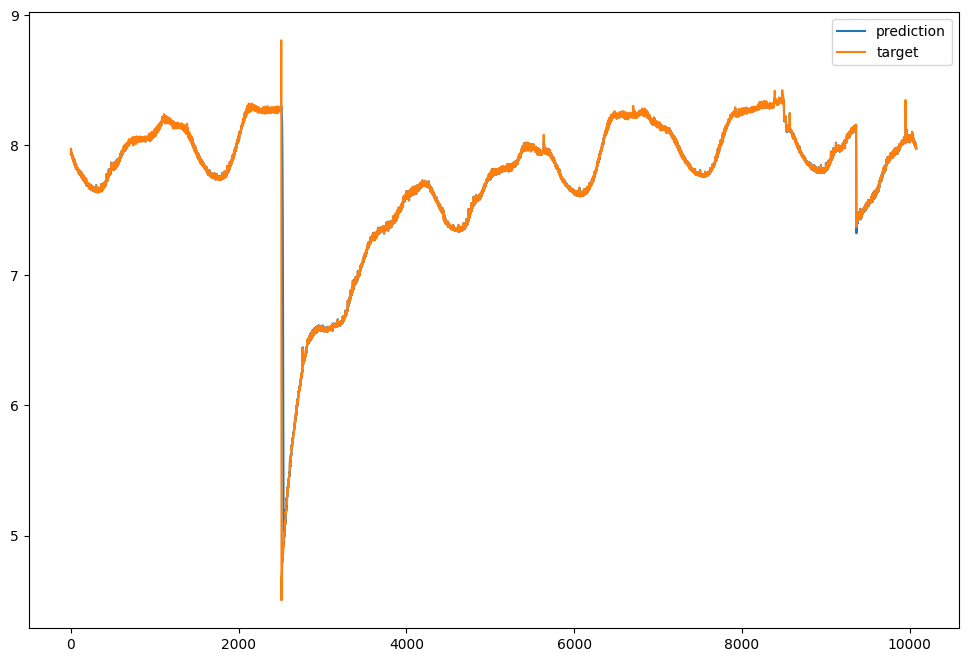

In [17]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [18]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.27773573994636536 %


SMAPE 0.35495781898498535 %

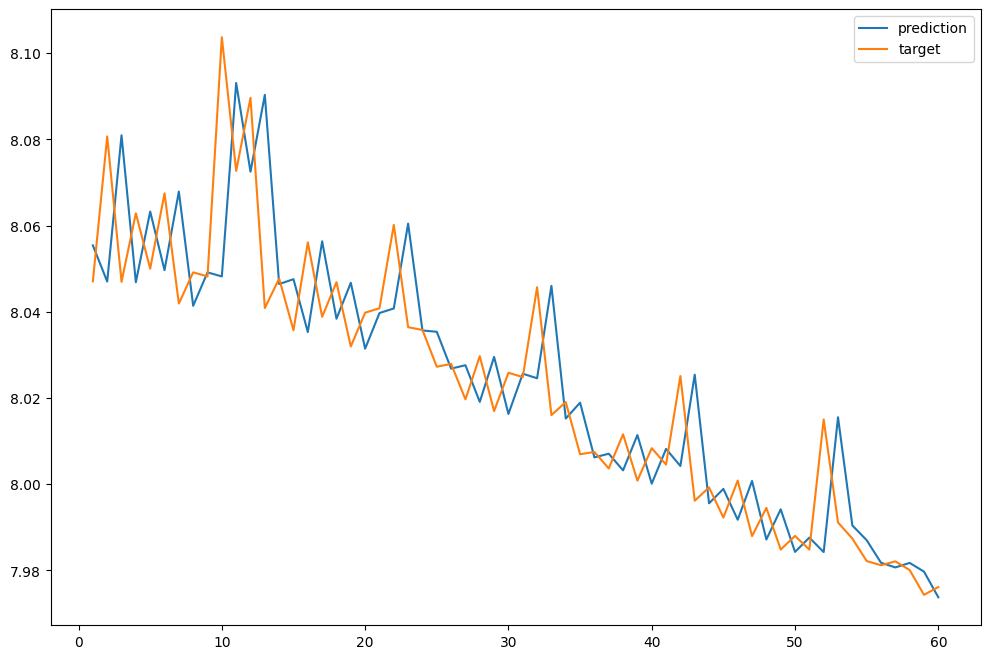

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [21]:
np.mean(time_list)

0.9061784945310108

<font color = blue><font size = 6> Conclusion </font></font><br>
DLienar online-learning과 NLinear online-learning에 비하면 매우 안좋은 SMAPE값이다 또한 한번 훈련하는데 0.6초가 걸렸는데 이는 속도가 무려 3배나 느리다는 것을 알려준다